In [586]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

# Create sample dataset to facilitate model testing

In [ ]:
dtypes={'userid': np.int32, 'movieid': np.int32, 'rating': np.float, 'timestamp': np.int8}
ratings_sample = pd.read_csv('data/ml-latest/split_movies/ratings_p00.csv')
names=ratings_sample.columns
ratings_sample = ratings_sample.drop(columns=['timestamp'])

ratings_sample.drop(index=np.random.choice(ratings_sample.shape[0], int(ratings_sample.shape[0]/26*25), replace=False), inplace=True)

pth = Path('data/ml-latest/split_movies/')
for i,child in enumerate(sorted(pth.iterdir())):
    if i==0:
        continue
    part = pd.read_csv('data/ml-latest/split_movies/'+child.name, dtype=dtypes, names=names) 
    part.drop(columns=['timestamp'], inplace=True)
    part.drop(index=np.random.choice(part.shape[0], int(part.shape[0]/27*26), replace=False), inplace=True)
    ratings_sample = ratings_sample.append(part)
gb=ratings_sample.groupby('userId')
ratings_sample = gb.filter(lambda x: x.shape[0]<100)
ratings_sample.reset_index(drop=True, inplace=True)

# Save train and test sets

In [2]:
m = ratings_sample.shape[0]
test_portion=.1
test_m = int(test_portion*m)

gb=ratings_sample.groupby('userId')
test_ds = gb.filter(lambda x: x.shape[0]>1)
gb = test_ds.groupby('userId', as_index=False)
test_ds = gb.apply(lambda x: x.loc[np.random.choice(x.index, 1)])
test_ds = test_ds.reset_index(level=0, drop=True)
test_ds=test_ds.loc[np.random.choice(test_ds.index, test_m, replace=False)]
test_ds.to_csv('data/test_set.csv', index=False)
ratings_sample.drop(index=test_ds.index, inplace=True)
ratings_sample.to_csv('data/ratings_sample.csv', index=False)

# Extract user IDs and movie IDs, normalize train rating

In [3]:
movies = ratings_sample.drop(columns='userId').groupby('movieId').mean()
ratings_sample = ratings_sample.merge(movies, how='left', left_on='movieId', right_index=True, suffixes=('','_mn'))
ratings_sample['rating_nrm']=ratings_sample.rating-ratings_sample.rating_mn
num_features=10
users = ratings_sample.userId.unique()
users.sort()

# Initialize model parameters

In [609]:
user_features = 4*np.random.rand(users.size, num_features)-2
user_features = pd.DataFrame(user_features, index=users)
movie_features = 4*np.random.rand(movies.shape[0], num_features)-2
movie_features = pd.DataFrame(movie_features, index=movies.index)

In [ ]:
test_ds.drop(index=test_ds[~test_ds.movieId.isin(movie_features.index)].index, inplace=True)

In [438]:
def costFunc(user_features, movie_features, y, lmbd=0):
    movie = y.movieId
    user=y.userId
    y_true=y.rating_nrm
#     print(y_true)
#     print(user_features.loc[user])
#     print(movie_features.loc[movie])
    prediction = user_features.loc[user].dot(movie_features.loc[movie])
    delta = (prediction-y_true)
    cost = delta**2/2
    return cost

In [495]:
def gradFunc(user_features, movie_features, y, lmbd=1e-4):
    movie = y.movieId
    user=y.userId
    y_true=y.rating_nrm
    prediction = user_features.loc[user].dot(movie_features.loc[movie])
    delta = (prediction-y_true)
    grad_t = delta*movie_features.loc[movie]+lmbd*user_features.loc[user]
    grad_x = delta*user_features.loc[user]+lmbd*movie_features.loc[movie]
    return grad_t, grad_x

In [443]:
def update_params(user_features, movie_features, y, grads_t, grads_x, alpha=.1):
    movie = y.movieId
    user=y.userId
    user_features.loc[user] -= alpha*grads_t
    movie_features.loc[movie] -= alpha*grads_x    

# Perform stochastic gradient descent

1.64896027605
0.00989576191251
4.445942318e-08
0.0539866786528


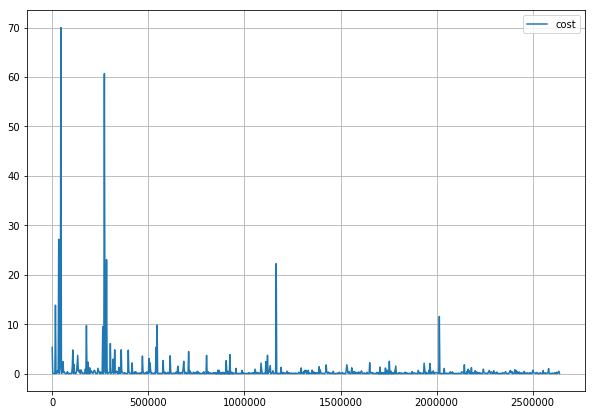

In [610]:
print(costFunc(user_features, movie_features, ratings_sample.loc[0]))
m_sam = ratings_sample.shape[0]
mod = int(m_sam/300)
x=[]
y=[]
lmbd = 1e-5 # 80/m_sam
for i in range(3):
    for index,row in ratings_sample.iterrows():
    #     cost = costFunc(user_features, movie_features, row)
        grad_t, grad_x = gradFunc(user_features, movie_features, row, lmbd)
        update_params(user_features, movie_features, row, grad_t, grad_x)
        if index % mod == 0:
            y += [costFunc(user_features, movie_features, row),]
            x += [index+i*m_sam,]
    print(costFunc(user_features, movie_features, ratings_sample.loc[0]))
plt.figure(figsize=[10,7])
plt.plot(x,y, label='cost')
plt.grid()
plt.legend()
plt.show()

In [612]:
movie_features.to_csv('data/movie_features.csv', index=False)

user_features.to_csv('data/user_features.csv', index=False)

# Final test set processing, score evaluation

In [635]:
prd = test_ds.apply(lambda x: user_features.loc[x.userId].dot(movie_features.loc[x.movieId])+movies.loc[x.movieId], axis=1)
prd.rating[prd.rating<0]=0
prd.rating[prd.rating>5]=5
MAE = np.abs(test_ds.rating-prd.rating).mean()
MAE